In [17]:
import torch
from abtem.core.energy import energy2wavelength
from tqdm import tqdm
import scipy
import sys
sys.path.append("../../functions")
from GS_data1d import intensity_profile, \
    construct_DM1d, propagation_dm1d, \
    standardize, drift, contrast_profile
from scipy.io import loadmat
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import eigh
from scipy.interpolate import interpn

100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


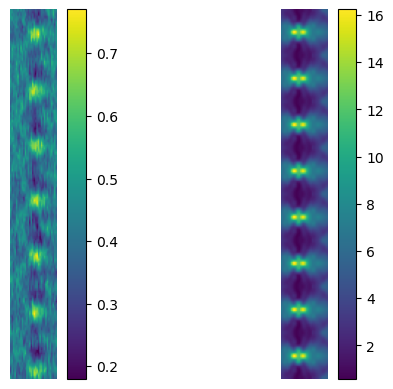

In [117]:
#Parameters
a = 3.905; energy=300e3; num_repeat = 8
#Load simulation data
image_series = loadmat("../../data/STO_3bc_simulation.mat")["image3"]
n_row, n_col, n_df = image_series.shape
focal_series = np.sum(image_series, axis=1)
focal_series_sim = np.tile(focal_series.T, num_repeat).T
n_rowp_sim = focal_series_sim.shape[0]
defocus_sim = np.arange(-20, 11, 2)*10
rx_sim = np.linspace(-a/2*num_repeat, a/2*num_repeat, n_rowp_sim)
sampling_sim = rx_sim[1]-rx_sim[0]
#Conduct construction
dm_rec, drift_list, stack_1dp = construct_DM1d(rx_sim, focal_series_sim, defocus_sim, sampling_sim, energy, n_iter=500)

focal_series_ex = scipy.io.loadmat("../../data/experiment_SREELS_STO_3BC_aligned.mat")["sreels_aligned"]
#focal_series_ex = np.flip(focal_series_ex, axis=1)
n_row, n_df = focal_series_ex.shape
a = 3.905; energy = 300e3; n_repeat = 8
rx_ex = np.linspace(-a*n_repeat/2, a*n_repeat/2, n_row)
sampling_ex = rx_ex[1] - rx_ex[0]
defocus_ex = np.arange(-30, 34, 2)*10
line_prof_ex = []
line_prof_sim = []
for n_df, df in enumerate(defocus_ex):
    line_ex = np.interp(rx_sim, rx_ex, focal_series_ex[:,n_df])
    line_prof_ex.append(line_ex)
    dm_prop = propagation_dm1d(dm_rec, df, energy, sampling_sim)
    line_sim = intensity_profile(dm_prop)
    line_prof_sim.append(line_sim)
focal_series_ex = np.array(line_prof_ex).T
focal_series_sim = np.array(line_prof_sim).T
plt.subplot(1, 2, 1)
plt.imshow(focal_series_ex)
plt.colorbar()
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(focal_series_sim)
plt.colorbar()
plt.axis("off")
plt.show()

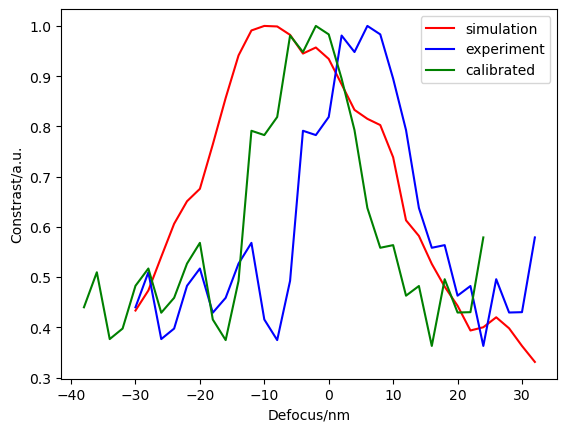

In [127]:
contrast_sim = contrast_profile(defocus_ex, focal_series_sim)
contrast_ex = contrast_profile(defocus_ex, focal_series_ex)
#calib_distance = 20; calib_factor = 1.6
calib_distance = 80; calib_factor = 1.6
#defocus_ex_adj = defocus_ex*calib_factor - calib_distance
defocus_ex_adj = defocus_ex - calib_distance
plt.plot(defocus_ex/10, contrast_sim, color='r', label='simulation')
plt.plot(defocus_ex/10, contrast_ex, color='b', label='experiment')
plt.plot(defocus_ex_adj/10, contrast_ex, color='g', label='calibrated')
plt.legend()
plt.xlabel("Defocus/nm")
plt.ylabel("Constrast/a.u.")
plt.show()

In [128]:
sampling = rx_sim[1] - rx_sim[0]
dm_rec, drift_list, stack_1dp = construct_DM1d(rx_sim, focal_series_ex, defocus_ex_adj, 
                                               sampling, energy, n_iter=500, drift_corr=False,
                                               filter_component=True, index_sel=30,
                                               apply_tcc=False)
#                                               apply_tcc=True, alpha=0.5e-3, Cs=1e-3)

100%|██████████| 500/500 [04:01<00:00,  2.07it/s]


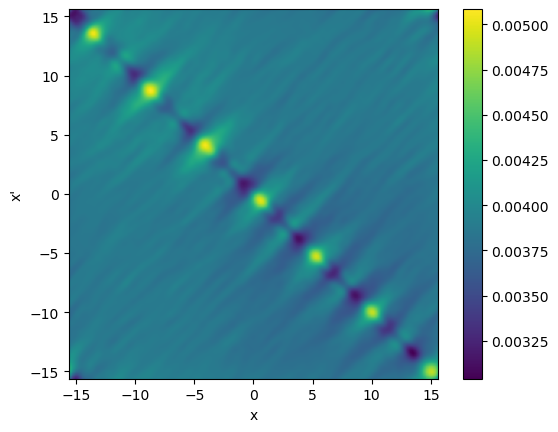

In [121]:
plt.imshow(np.abs(dm_rec/np.trace(dm_rec)), extent=[-a*n_repeat/2, a*n_repeat/2, -a*n_repeat/2, a*n_repeat/2])
plt.colorbar()
plt.xlabel("x")
plt.ylabel("x'")
#plt.axis("off")
plt.show()

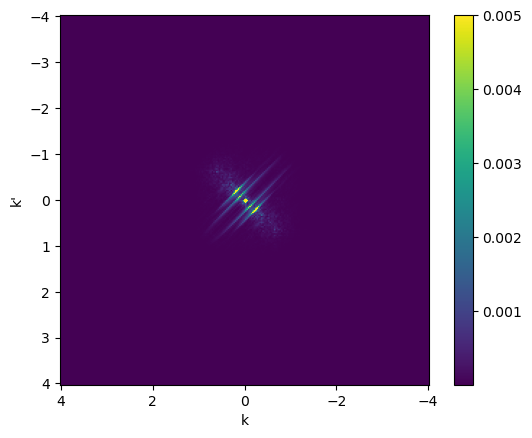

In [122]:
kdm_rec = np.fft.fftshift(np.fft.fft2(dm_rec))
kx = np.fft.fftfreq(n_row, sampling)
ak = np.max(kx)
plt.imshow(np.abs(kdm_rec/np.trace(kdm_rec)), vmax=0.005, extent=[ak, -ak, ak, -ak])
plt.colorbar()
plt.xlabel("k")
plt.ylabel("k'")
#plt.axis("off")
plt.show()

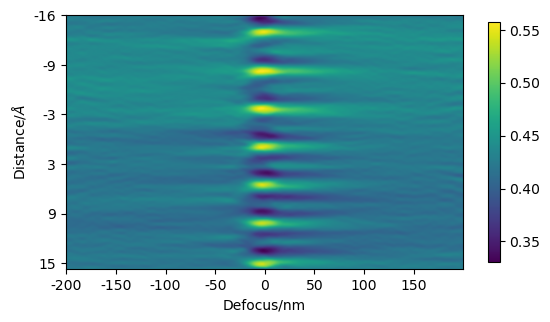

In [123]:
extend_defocus = np.arange(-200, 200, 1)*10
defocus_stack = []
for i, df in enumerate(extend_defocus):
    dm_prop = propagation_dm1d(dm_rec, df, energy, sampling)
    intensity = intensity_profile(dm_prop)
    #comparison = focal_series[:,i]
    defocus_stack.append(intensity)
defocus_stack = np.array(defocus_stack)
plt.imshow(defocus_stack.T)
x_labels = np.arange(0, len(extend_defocus), 50)
xlab = [f"{extend_defocus[i]/10:.0f}" for i in x_labels]
plt.xticks(ticks=x_labels, labels=xlab)
y_labels = np.arange(0, len(rx_sim), 50)
ylab = [f"{rx_sim[i]:.0f}" for i in y_labels]
plt.yticks(ticks=y_labels, labels=ylab)
plt.xlabel("Defocus/nm")
plt.ylabel(r"Distance/$\AA$")
plt.colorbar(shrink=0.65)
plt.show()

In [124]:
len(defocus_ex_adj)

32

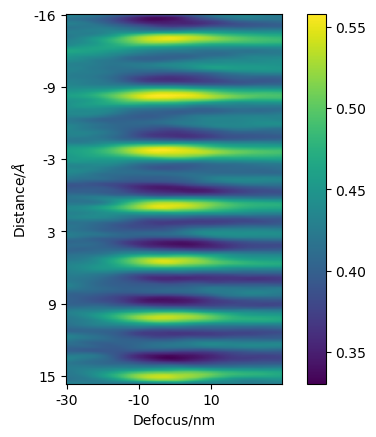

In [125]:
#extend_defocus = defocus
extend_defocus = np.linspace(-30, 30, 150)*10
defocus_stack = []
for i, df in enumerate(extend_defocus):
    dm_prop = propagation_dm1d(dm_rec, df, energy, sampling)
    intensity = intensity_profile(dm_prop)
    #comparison = focal_series[:,i]
    defocus_stack.append(intensity)
defocus_stack = np.array(defocus_stack)
plt.imshow(defocus_stack.T)
x_labels = np.arange(0, len(extend_defocus), 50)
xlab = [f"{extend_defocus[i]/10:.0f}" for i in x_labels]
plt.xticks(ticks=x_labels, labels=xlab)
y_labels = np.arange(0, len(rx_sim), 50)
ylab = [f"{rx_sim[i]:.0f}" for i in y_labels]
plt.yticks(ticks=y_labels, labels=ylab)
plt.xlabel("Defocus/nm")
plt.ylabel(r"Distance/$\AA$")
plt.colorbar()
plt.show()

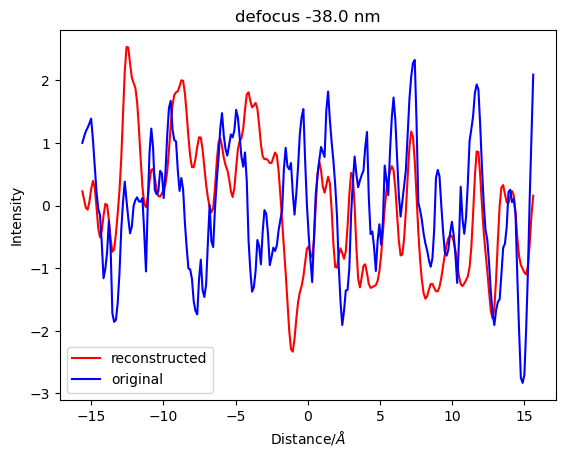

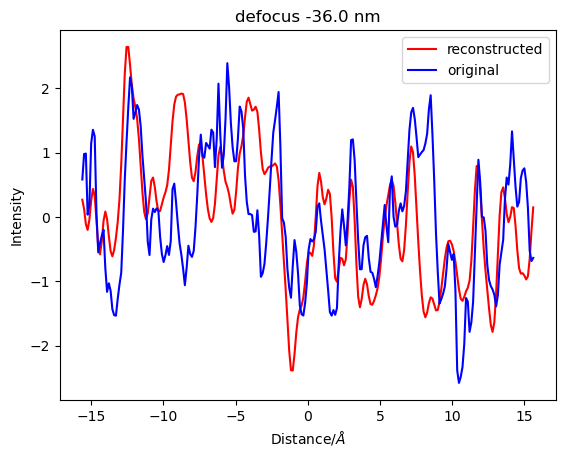

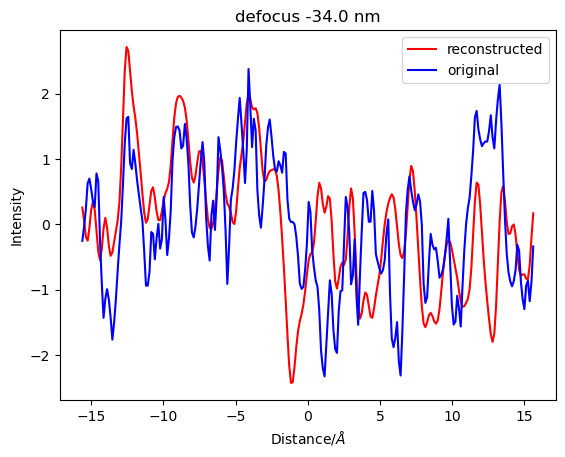

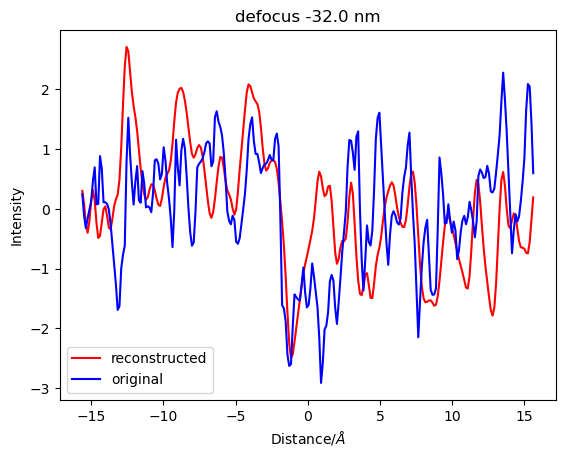

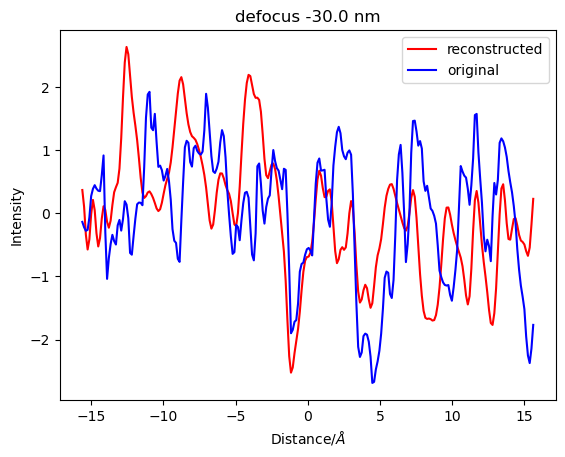

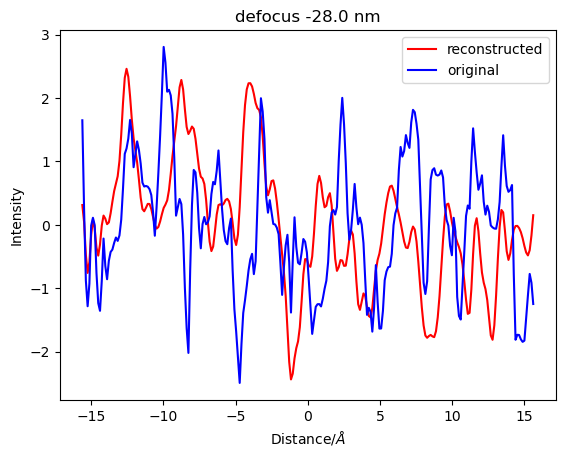

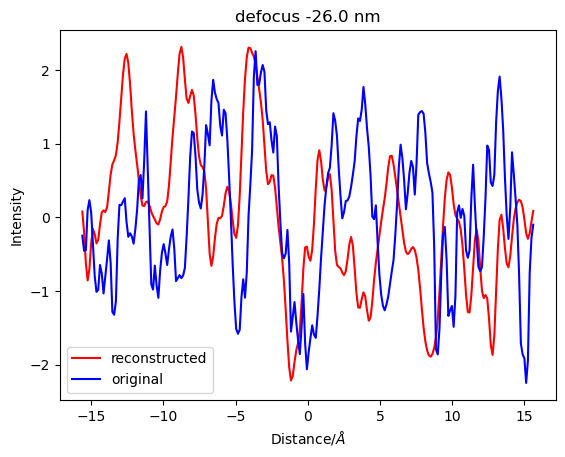

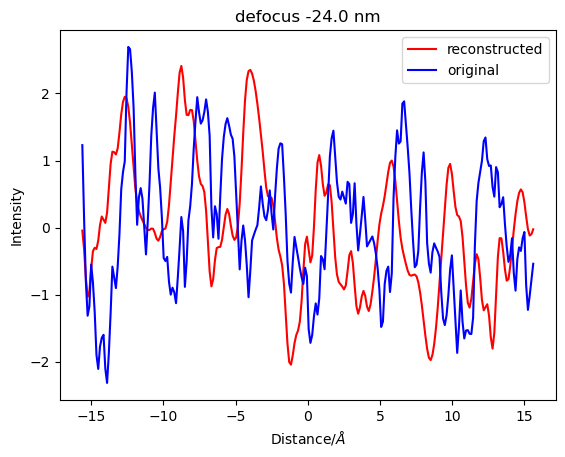

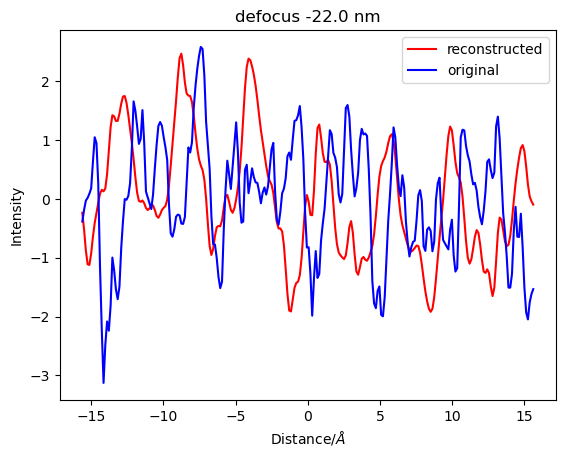

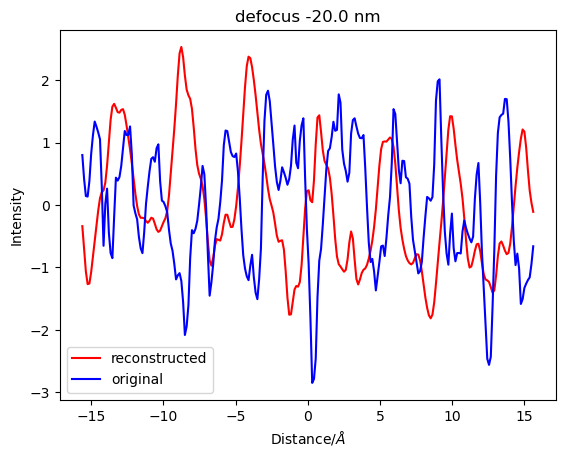

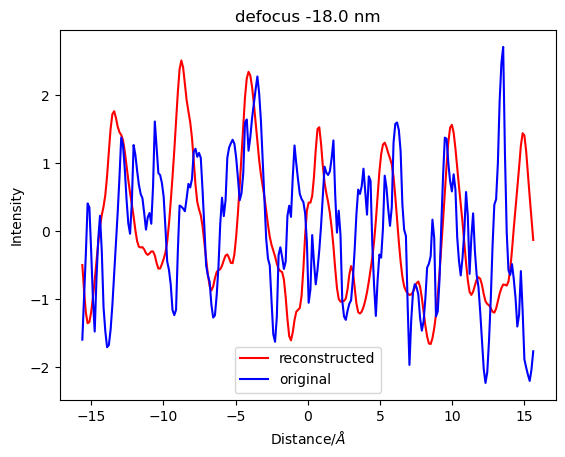

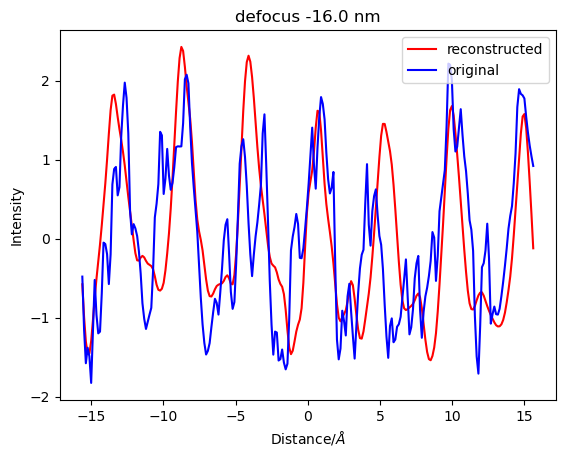

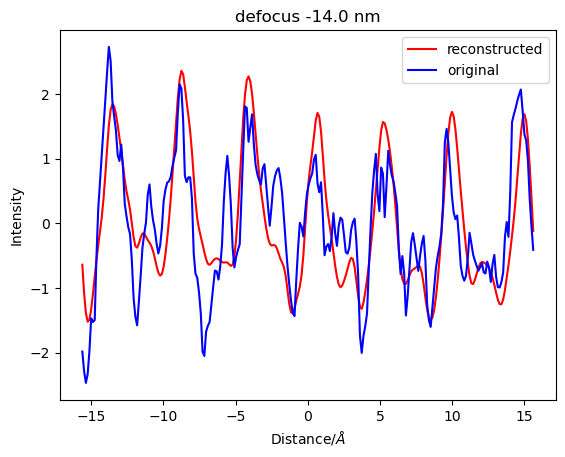

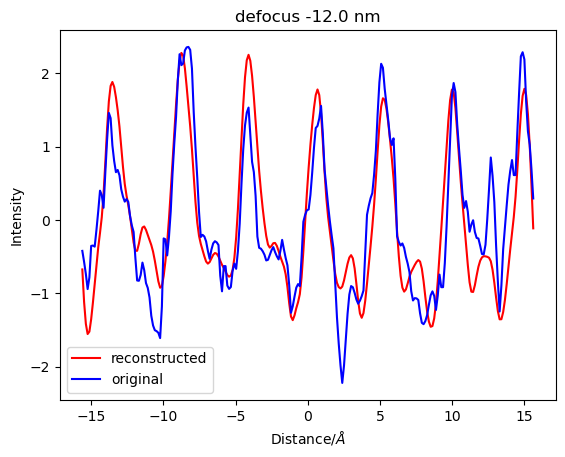

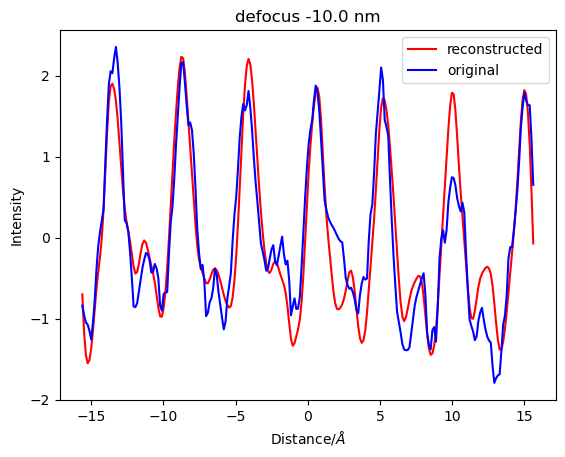

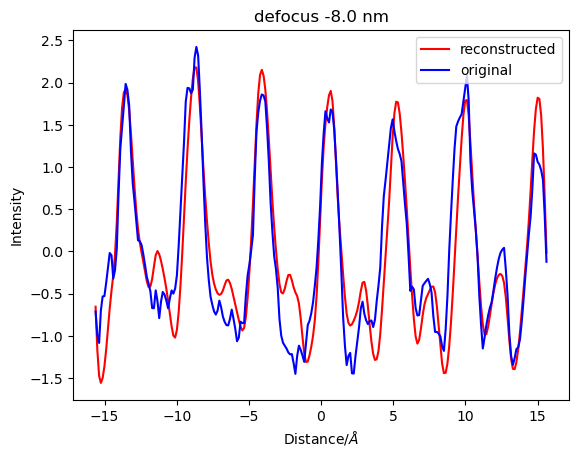

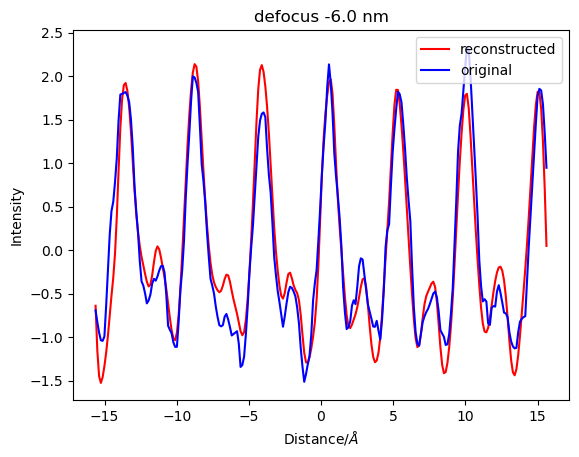

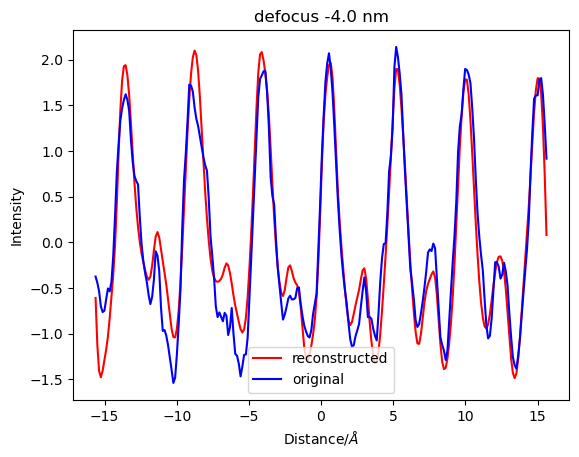

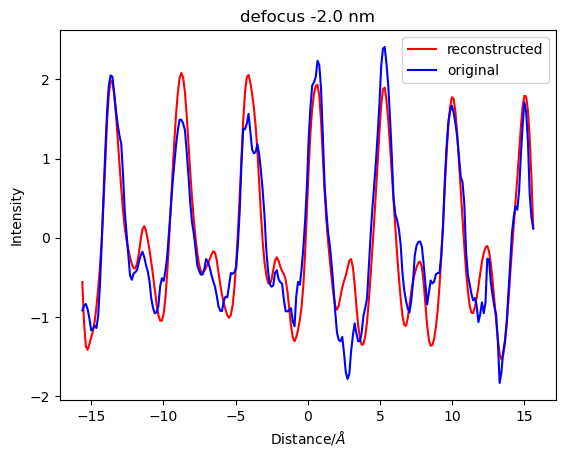

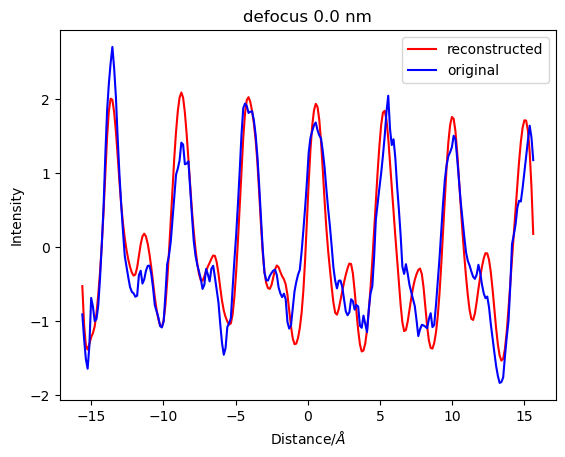

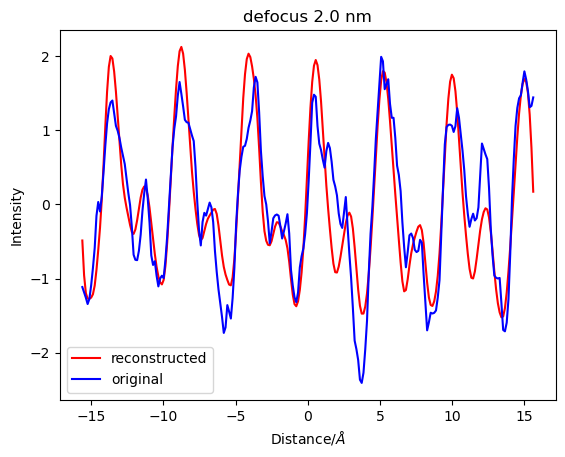

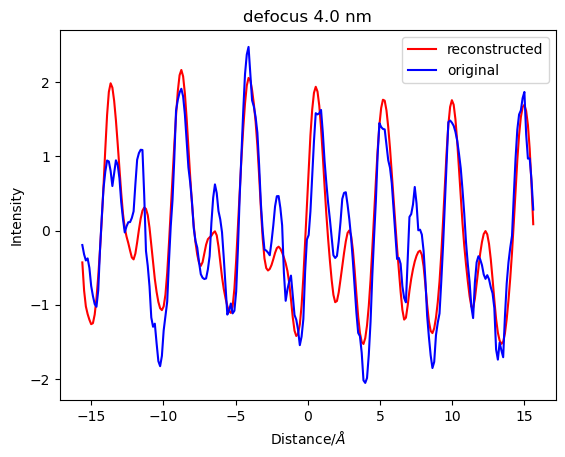

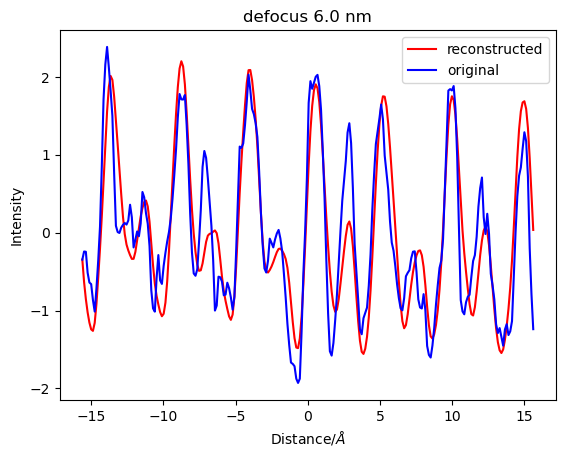

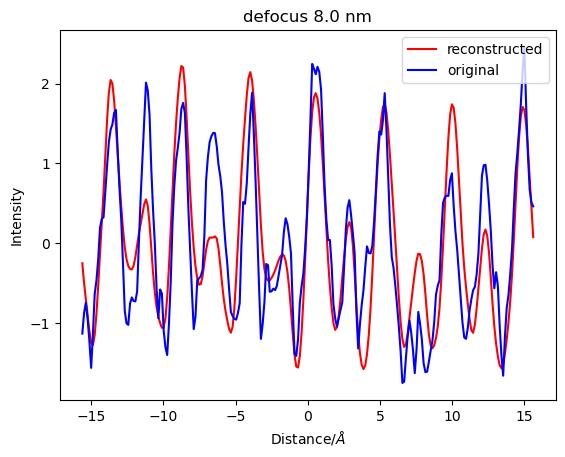

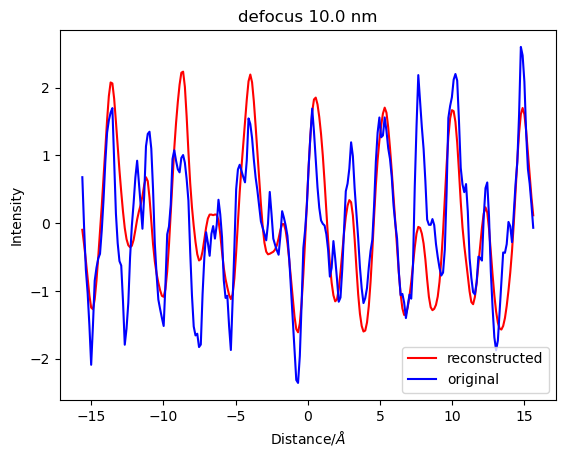

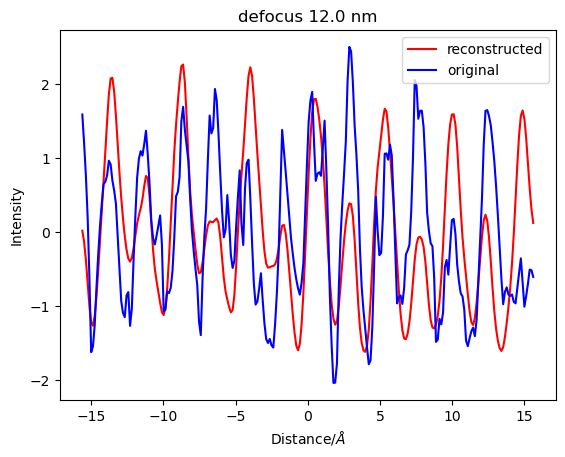

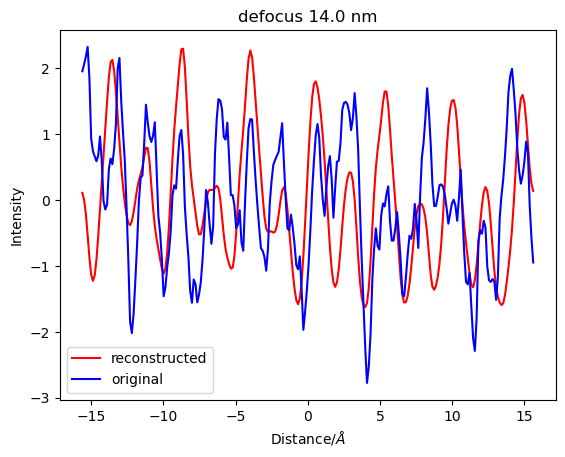

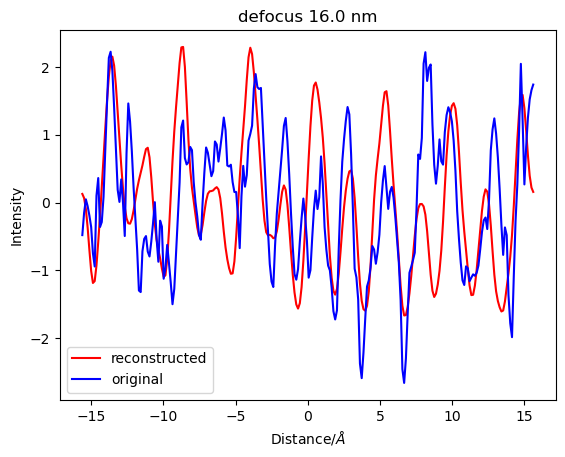

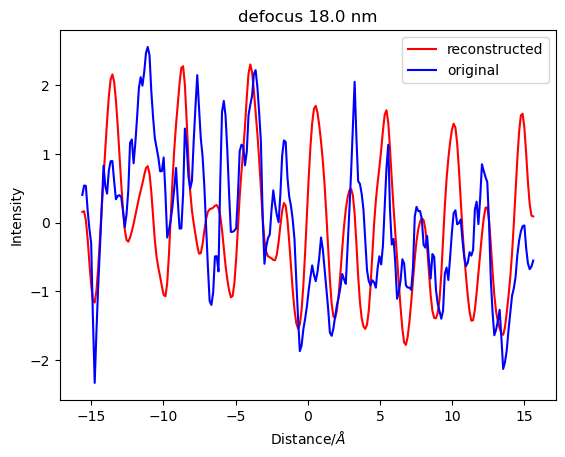

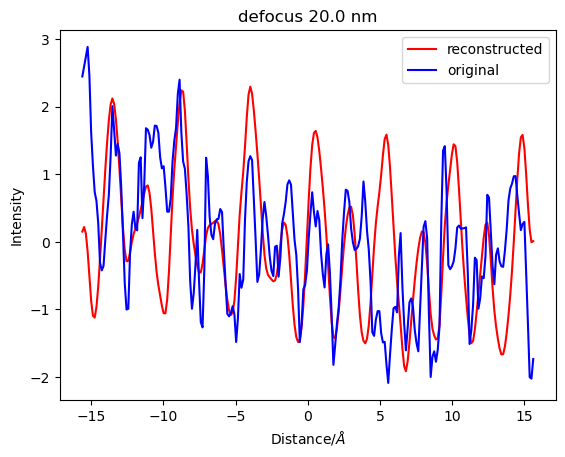

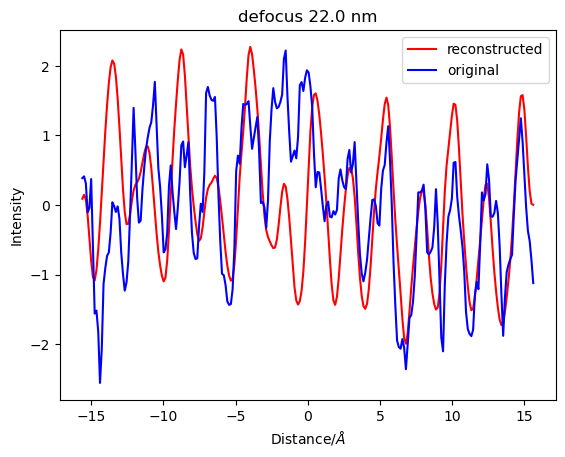

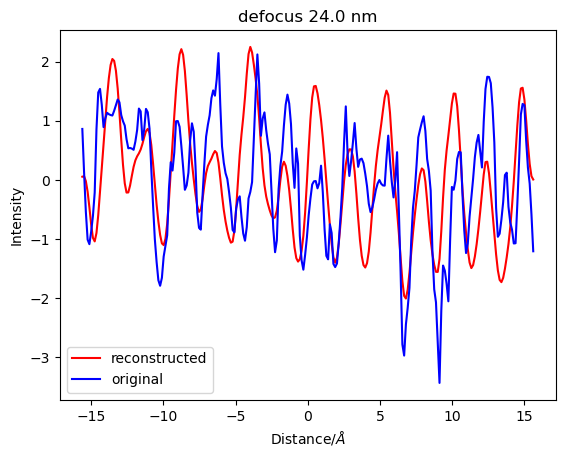

In [126]:
reconstructed_profile = []
for n_df, df in enumerate(defocus_ex_adj):
    dm_prop = propagation_dm1d(dm_rec, df, energy, sampling_sim)
    line_sim = intensity_profile(dm_prop)
    reconstructed_profile.append(line_sim)
    line_ex = focal_series_ex[:,n_df]
    plt.plot(rx_sim, standardize(line_sim), color='r', label="reconstructed")
    plt.plot(rx_sim, standardize(line_ex), color='b', label="original")
    plt.xlabel(r"Distance/$\AA$")
    plt.ylabel("Intensity")
    plt.title(f"defocus {df/10} nm")
    plt.legend()
    plt.show()
reconstructed_profile = np.array(reconstructed_profile)

/var/folders/06/8n008hdd2ls9jb4qk47sydy00000gn/T/ipykernel_93422/531167659.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


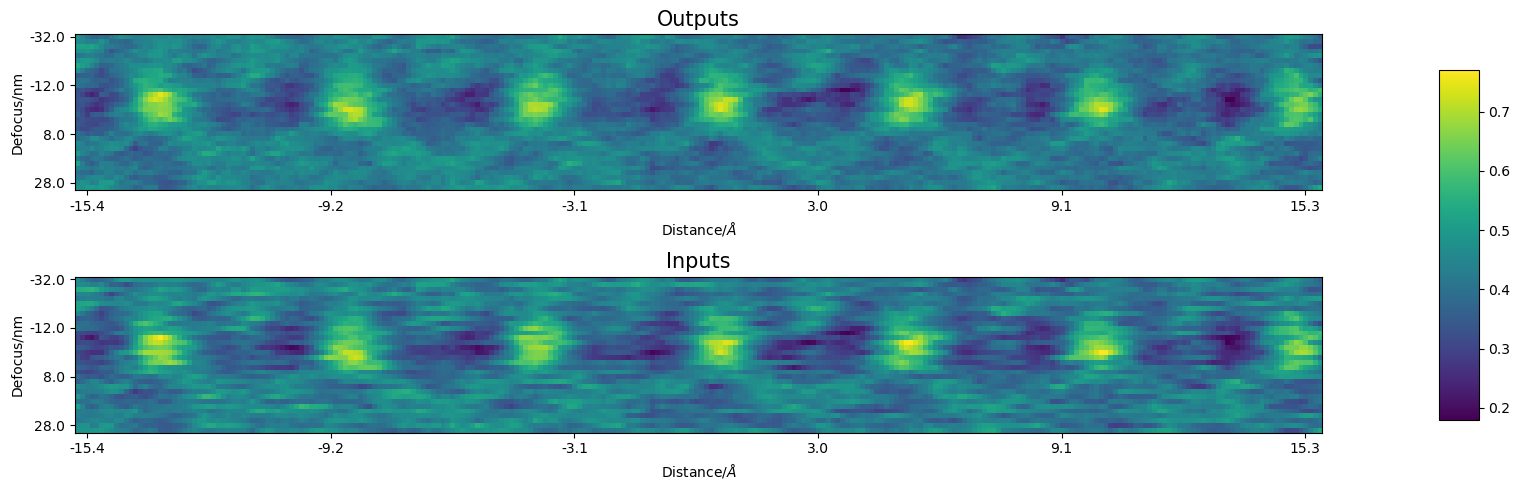

In [105]:
fig, axs = plt.subplots(2, 1, figsize=(20, 5))
ax = axs[0]
vmin = np.min(focal_series_ex); vmax = np.max(focal_series_ex)
ax.imshow(reconstructed_profile, vmin=vmin, vmax=vmax)
sel_labelx = np.arange(2, len(rx_sim), 50)
x_labels= [f"{rx_sim[i]:.1f}" for i in sel_labelx]
ax.set_xticks(ticks=sel_labelx, labels=x_labels)
sel_labely = np.arange(0, len(defocus_ex_adj), 10)
y_labels= [f"{defocus_ex_adj[i]/10:.1f}" for i in sel_labely]
ax.set_yticks(ticks=sel_labely, labels=y_labels)
ax.set_xlabel(r"Distance/$\AA$")
ax.set_ylabel("Defocus/nm")
ax.set_title("Outputs", fontsize=15)
ax = axs[1]
im = ax.imshow(focal_series_ex.T, vmin=vmin, vmax=vmax)
sel_labelx = np.arange(2, len(rx_sim), 50)
x_labels= [f"{rx_sim[i]:.1f}" for i in sel_labelx]
ax.set_xticks(ticks=sel_labelx, labels=x_labels)
sel_labely = np.arange(0, len(defocus_ex_adj), 10)
y_labels= [f"{defocus_ex_adj[i]/10:.1f}" for i in sel_labely]
ax.set_yticks(ticks=sel_labely, labels=y_labels)
ax.set_xlabel(r"Distance/$\AA$")
ax.set_ylabel("Defocus/nm")
ax.set_title("Inputs", fontsize=15)
fig.subplots_adjust(right=1)
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout()
plt.show()

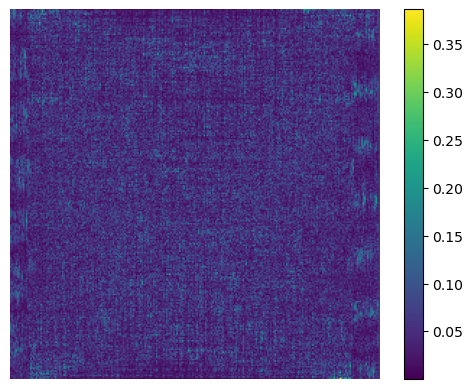

In [102]:
w, v = eigh(dm_rec)
plt.imshow(np.abs(v))
plt.colorbar()
plt.axis("off")
plt.show()

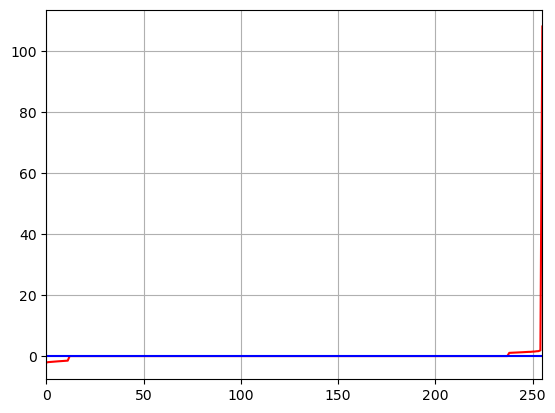

In [103]:
series = w
plt.plot(series, color='r')
plt.plot(np.zeros(series.shape), color='b')
plt.xlim([0, series.shape[0]-1])
plt.grid()
plt.show()

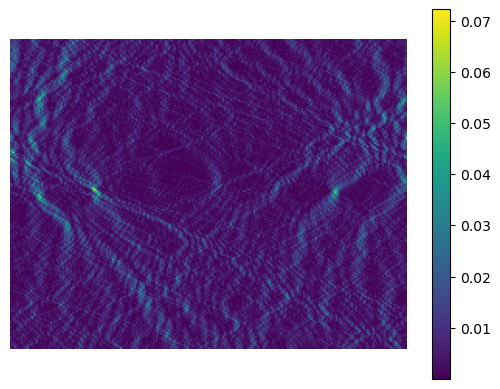

In [104]:
w, v = eigh(dm_rec)
index = 18
#w[:index] = 0; w[index+1:] = 0
index = -6
w[:index] = 0; w[index+1:]=0
w[-1] = 0
dm_sel = v @ np.diag(w) @ v.conj().T

#extend_defocus = defocus
extend_defocus = np.arange(-100, 100, 1)*10
defocus_stack = []
for i, df in enumerate(extend_defocus):
    dm_prop = propagation_dm1d(dm_sel, df, energy, sampling)
    intensity = intensity_profile(dm_prop)
    #comparison = focal_series[:,i]
    defocus_stack.append(intensity)
defocus_stack = np.array(defocus_stack)
plt.imshow(defocus_stack)
plt.colorbar()
plt.axis("off")
plt.show()